In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import data_util  
from sklearn.svm import SVC
yf.pdr_override()

sns.set(rc={'figure.figsize':(20, 15)})

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))

import warnings
warnings.filterwarnings('ignore')


In [9]:
apple_stocks=data_util.stock_data('AAPL', 4,'Apple')

[*********************100%%**********************]  1 of 1 completed


PREPARING OUR DATASET USING TIME SERIES CROSS - VALIDATION , THE IMAGE ATTACHED BELOW PROVIDES INSIGHT ONTO HOW WE WANT TO IMPLEMENT CROSSVALIDATION TO OUR TIME SERIES DATA.

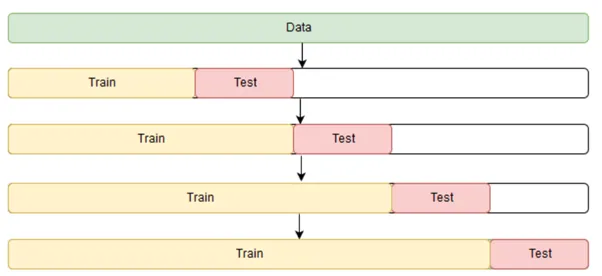

In [10]:
def time_series_cross_validation(df,one_hot_encodings,p):

  # test_percentage = [0.2,0.4,0.6,0.8] #these represent the split between the train and test
    row = int(df.shape[0]*p)
    val_row = int( (df.shape[0]-row)*0.5) + row

    #create the training and validation dataset
    x_train = temp[:row]
    y_train = one_hot_encodings[:row]

    x_val = temp[row:val_row]
    y_val = one_hot_encodings[row:val_row]

    x_test = temp[val_row:]
    y_test = one_hot_encodings[val_row:]

    return x_train,y_train,x_val,y_val,x_test,y_test

def time_series_cross_validation_regression(df,x,y,p):

  # test_percentage = [0.2,0.4,0.6,0.8] #these represent the split between the train and test
    row = int(df.shape[0]*p)
    val_row = int( (df.shape[0]-row)*0.5) + row

    #create the training and validation dataset
    x_train = x[:row]
    y_train = y[:row]

    x_val = x[row:val_row]
    y_val = y[row:val_row]

    x_test = x[val_row:]
    y_test = y[val_row:]

    return x_train,y_train,x_val,y_val,x_test,y_test

**PART 1** - IMPLEMENTING A BASIC CLASSIFYING STRATEGY WHICH TELLS US WHETHER TO BUY OR NOT BUY USING SUPPORT VECTOR CLASSIFIERS

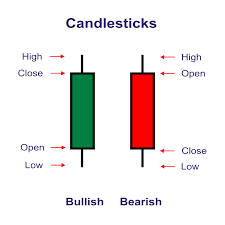

**PART 2** - CREATING THE NECESSARY FEATURES THAT WE REQUIRE

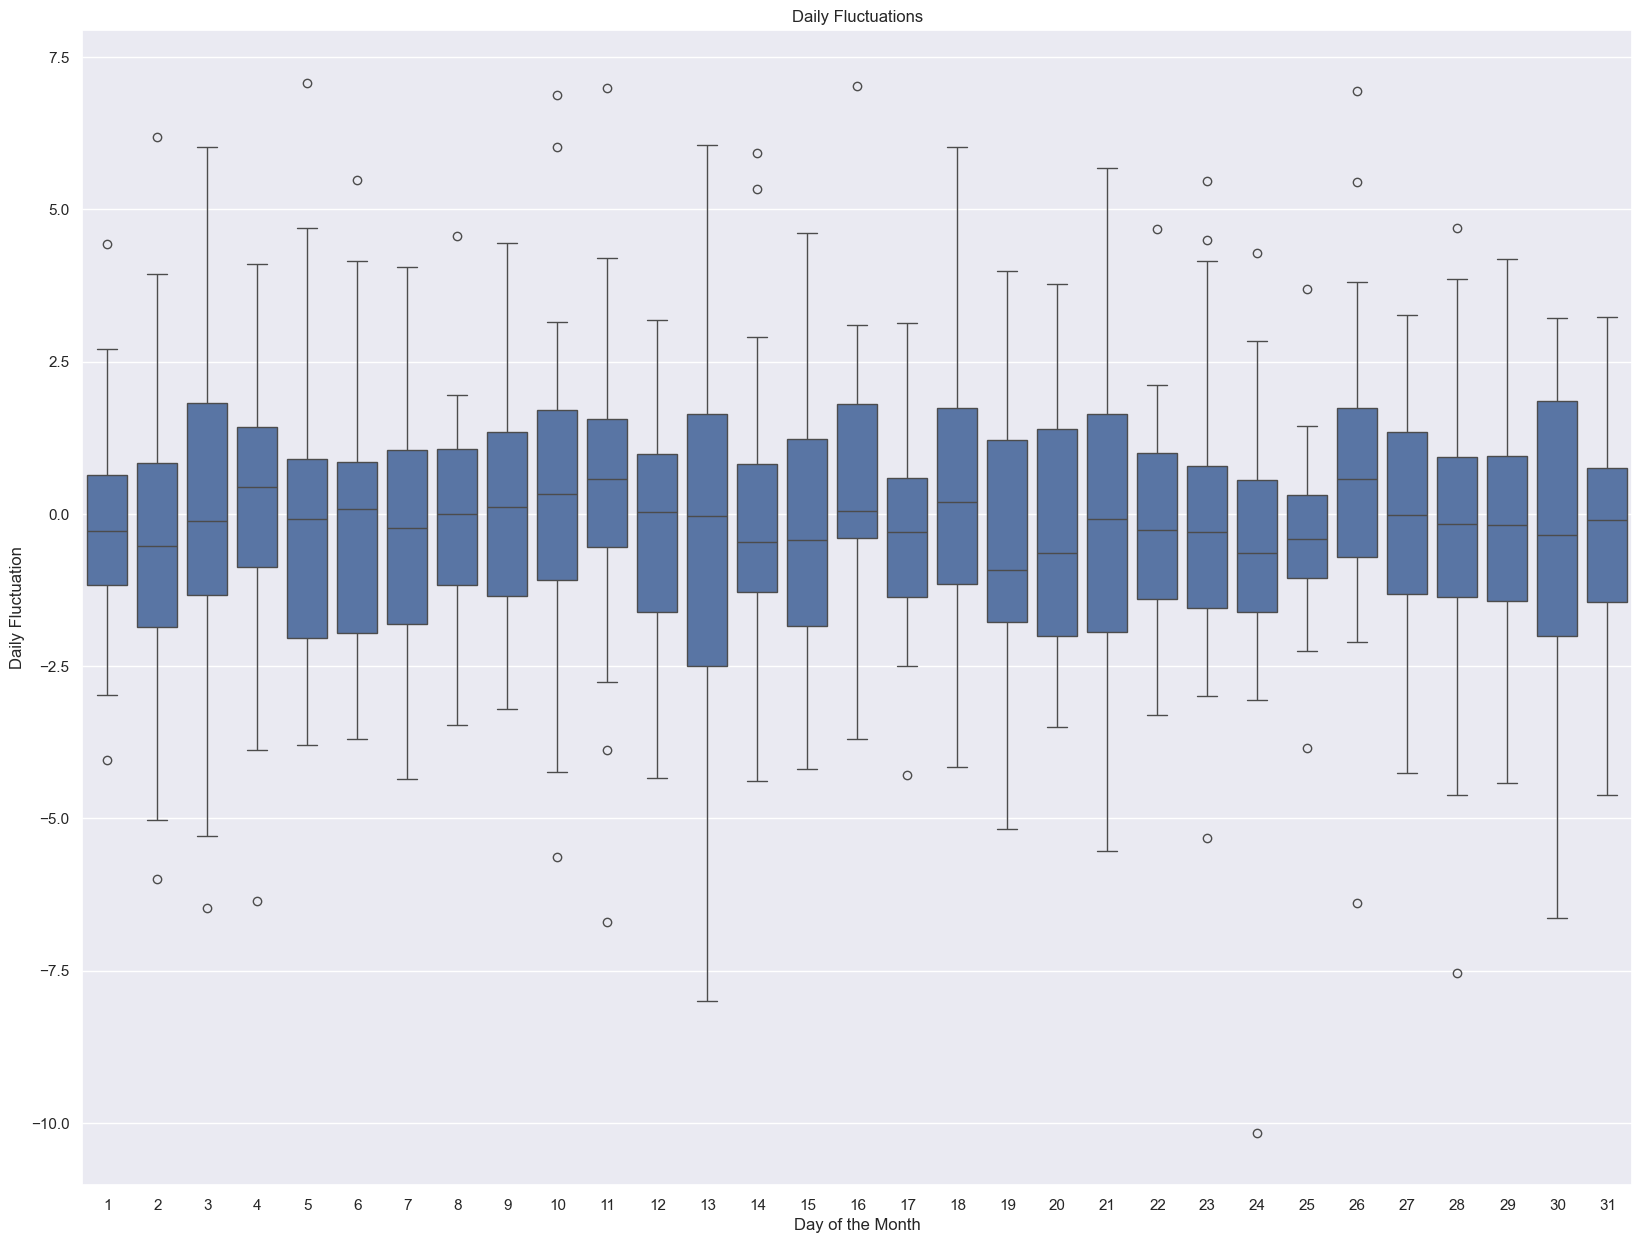

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_features(apple_stocks):

    apple_stocks["Daily-Max-Fluctuation"] = apple_stocks["High"] - apple_stocks["Low"]

    apple_stocks["Daily-Fluctuation"] = apple_stocks["Open"] - apple_stocks["Close"]

    temp = apple_stocks[["Daily-Fluctuation", "Daily-Max-Fluctuation", "Close"]]

    apple_stocks['Day'] = apple_stocks.index.day

    return temp, apple_stocks

def plot_daily_fluctuations(apple_stocks):
    sns.boxplot(data=apple_stocks, x="Day", y="Daily-Fluctuation")
    plt.title('Daily Fluctuations')
    plt.xlabel('Day of the Month')
    plt.ylabel('Daily Fluctuation')
    plt.show()


temp, apple_stocks = create_features(apple_stocks)
plot_daily_fluctuations(apple_stocks)


**Part 3**- Now we prepare our y - labels. Instead of directly using the next day's price in our model , our naive model initially predicts whether it should buy or sell the stock the next day.

In [12]:
buy_or_sell = np.where(apple_stocks.Close.shift(-1) > apple_stocks.Close,1,0)

**Part 4** - Training a support vector classifier for our 0/1 classification objective

In [13]:
import seaborn as sns

def plot_returns(apple_stocks):
    apple_stocks['return'] = apple_stocks['Close'].pct_change(1)

    # Shift predictions and calculate strategy returns
    apple_stocks['shifted_predictions'] = apple_stocks['predictions'].shift(1)
    apple_stocks['strategy_returns'] = apple_stocks['shifted_predictions'] * apple_stocks['return']

    ret = [0]  # initialize with 0
    strat = [0]
    for i in range(1, len(apple_stocks)):
        ret.append(ret[-1] + apple_stocks['return'].iloc[i])
        strat.append(strat[-1] + apple_stocks['strategy_returns'].iloc[i])
    apple_stocks['ret'] = ret
    apple_stocks['strat'] = strat

    # Plot using seaborn
    sns.lineplot(data=apple_stocks, x=apple_stocks.index, y='ret', color='red', label='Predicted Strategy Returns')
    sns.lineplot(data=apple_stocks, x=apple_stocks.index, y='strat', color='blue', label='Actual Stock Returns')
    plt.title('Returns')
    plt.legend()
    plt.show()



def SVC_Classifier(apple_stocks, x_train, y_train, x_val, y_val, x_test, y_test, X):
    model = SVC()
    model.fit(x_train[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_train)

    train_err = model.score(x_train[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_train)
    test_err = model.score(x_test[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_test)
    val_err = model.score(x_val[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_val)

    apple_stocks['predictions'] = model.predict(X[["Daily-Fluctuation", "Daily-Max-Fluctuation"]])

    print("The model's score for the Test Set came out to be : ", test_err)
    print("The model's score for the Validation Set came out to be : ", val_err)
    plot_returns(apple_stocks)

Train - Test Split :  20.0 - 80.0
The model's score for the Test Set came out to be :  0.5062034739454094
The model's score for the Validation Set came out to be :  0.5235732009925558


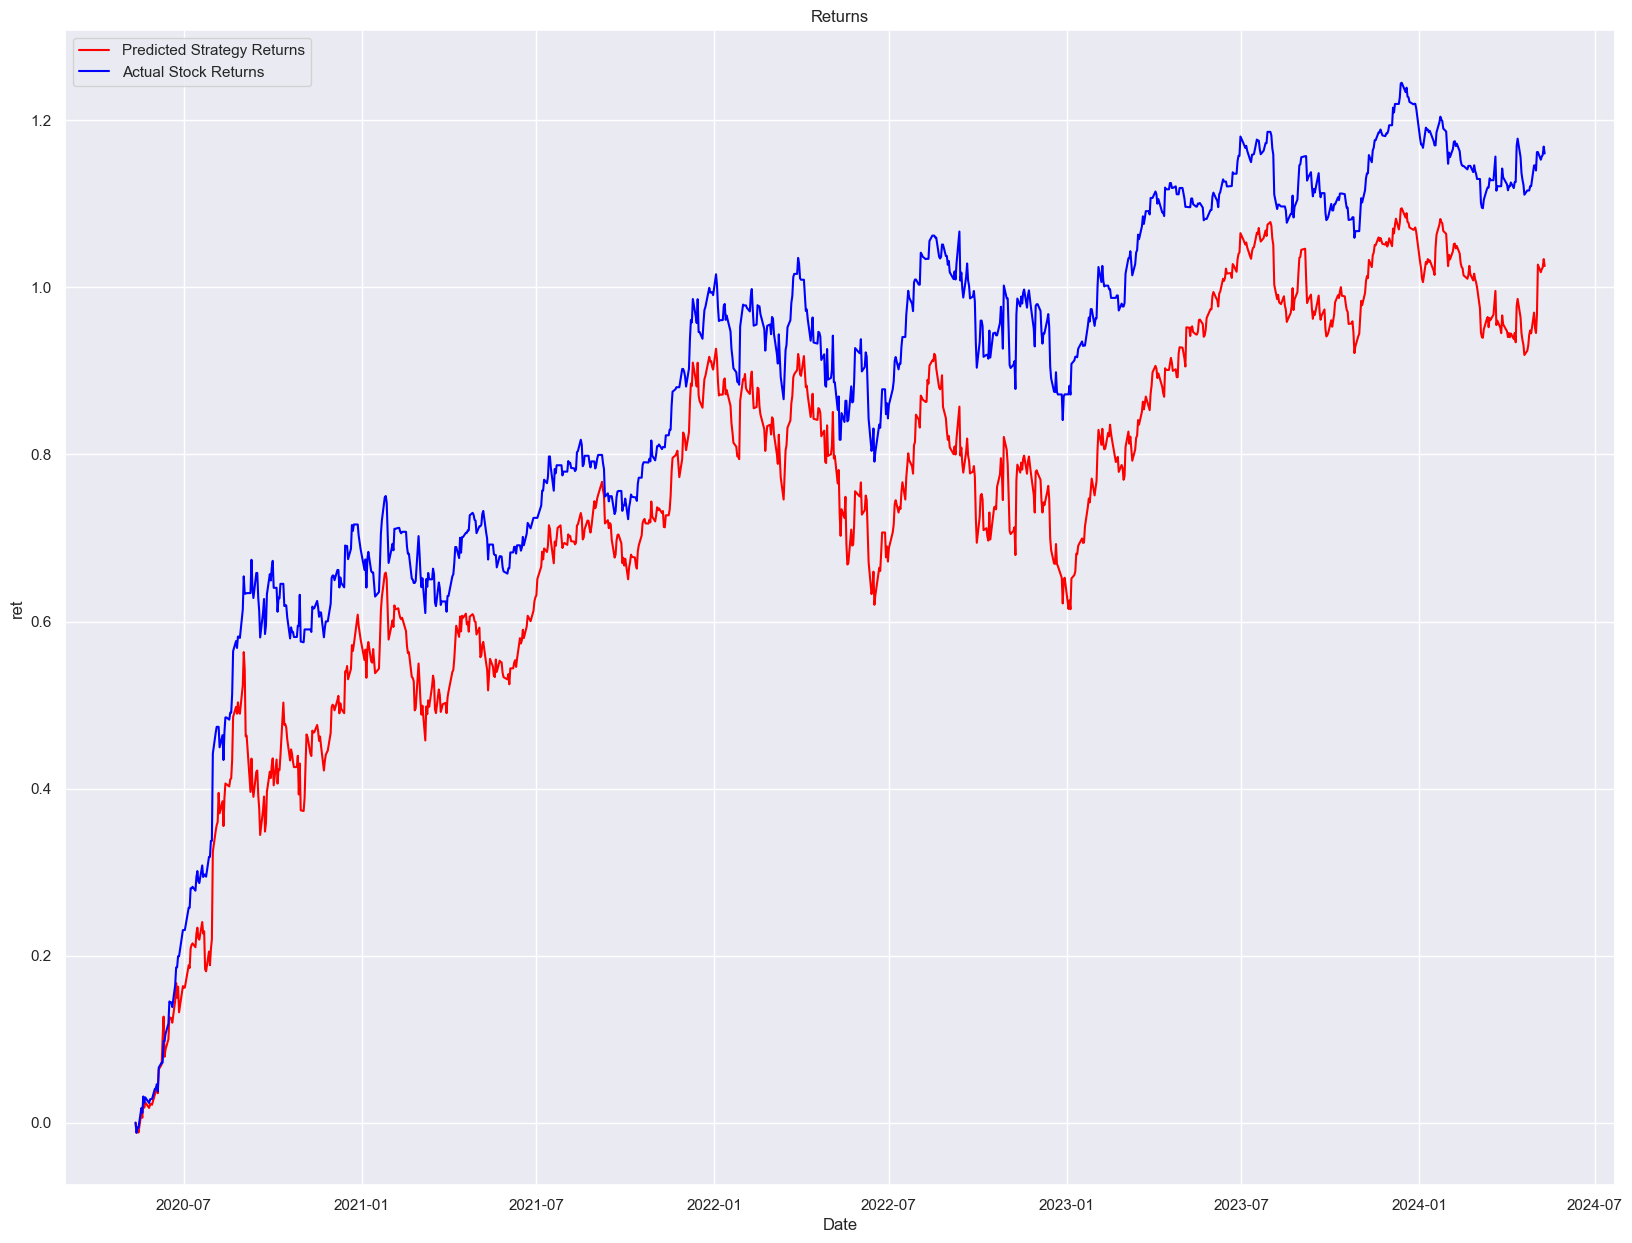

Train - Test Split :  40.0 - 60.0
The model's score for the Test Set came out to be :  0.504950495049505
The model's score for the Validation Set came out to be :  0.4900662251655629


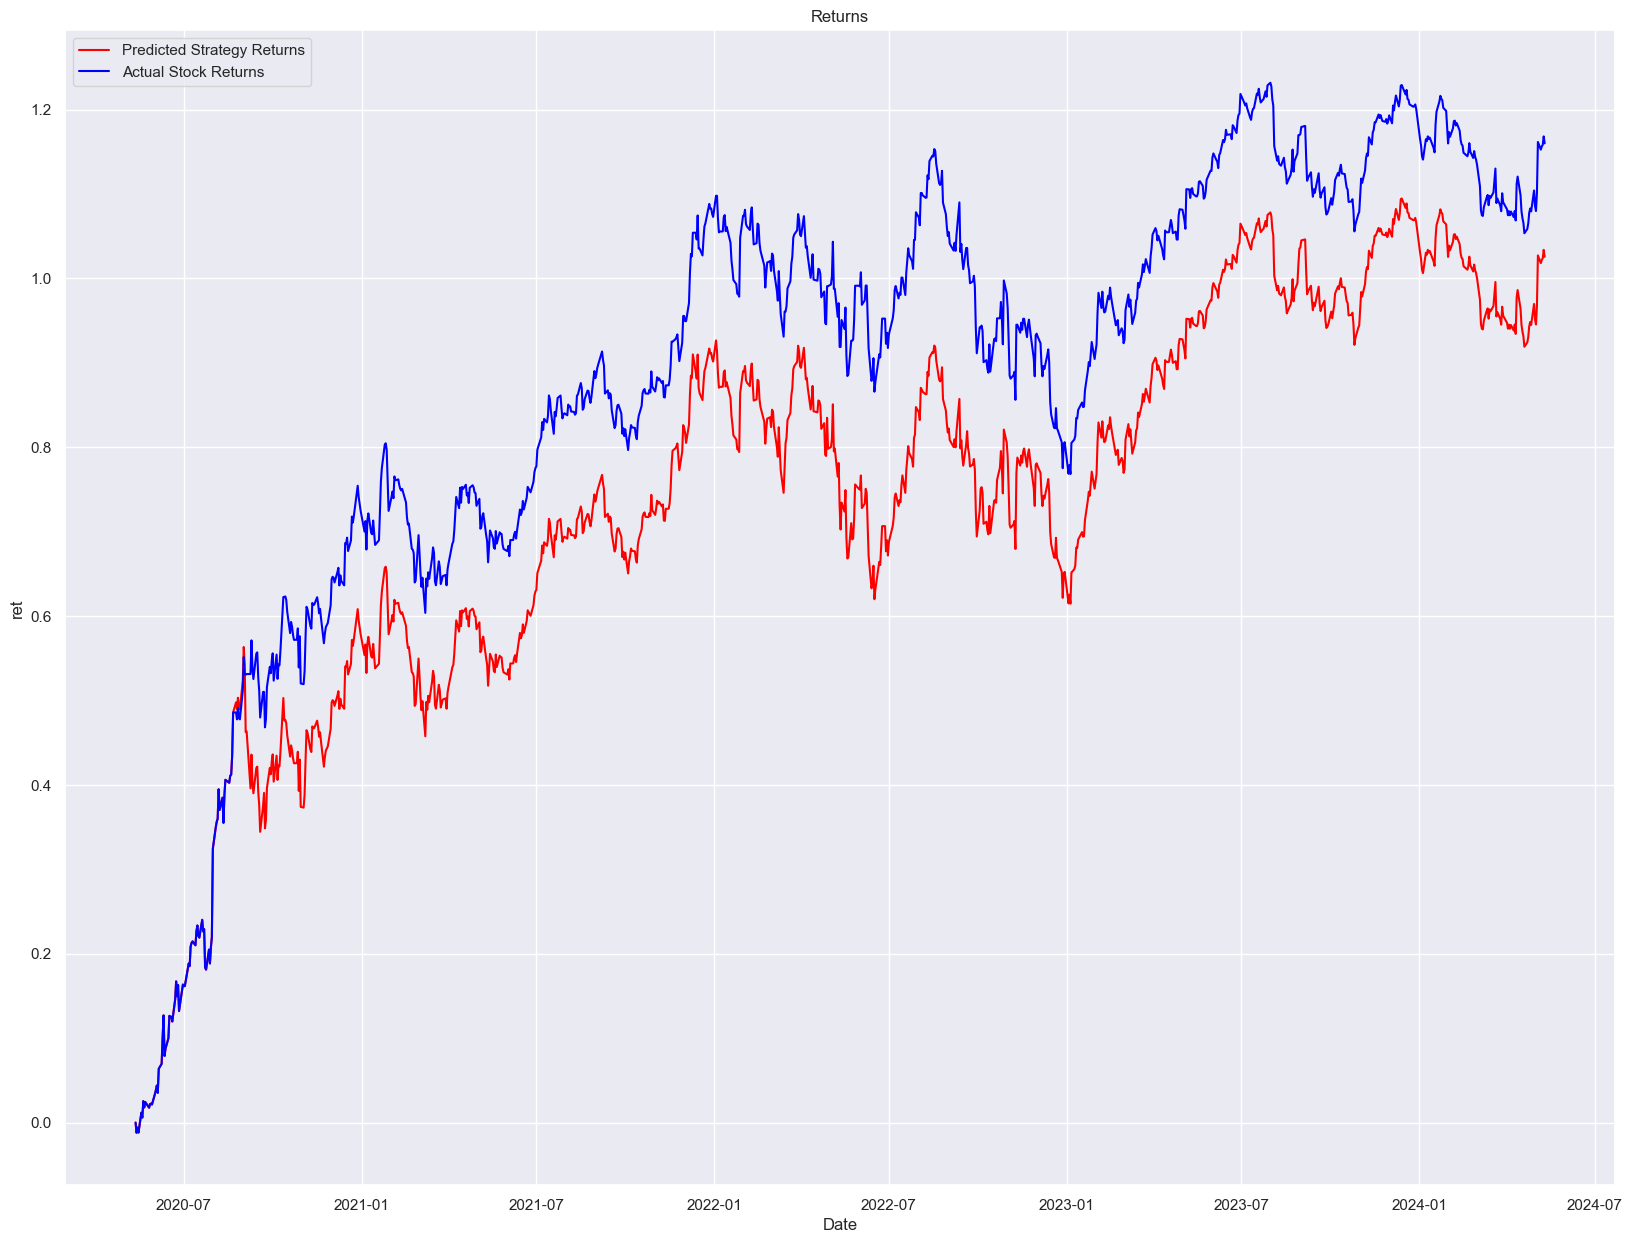

Train - Test Split :  60.0 - 40.0
The model's score for the Test Set came out to be :  0.4752475247524752
The model's score for the Validation Set came out to be :  0.5124378109452736


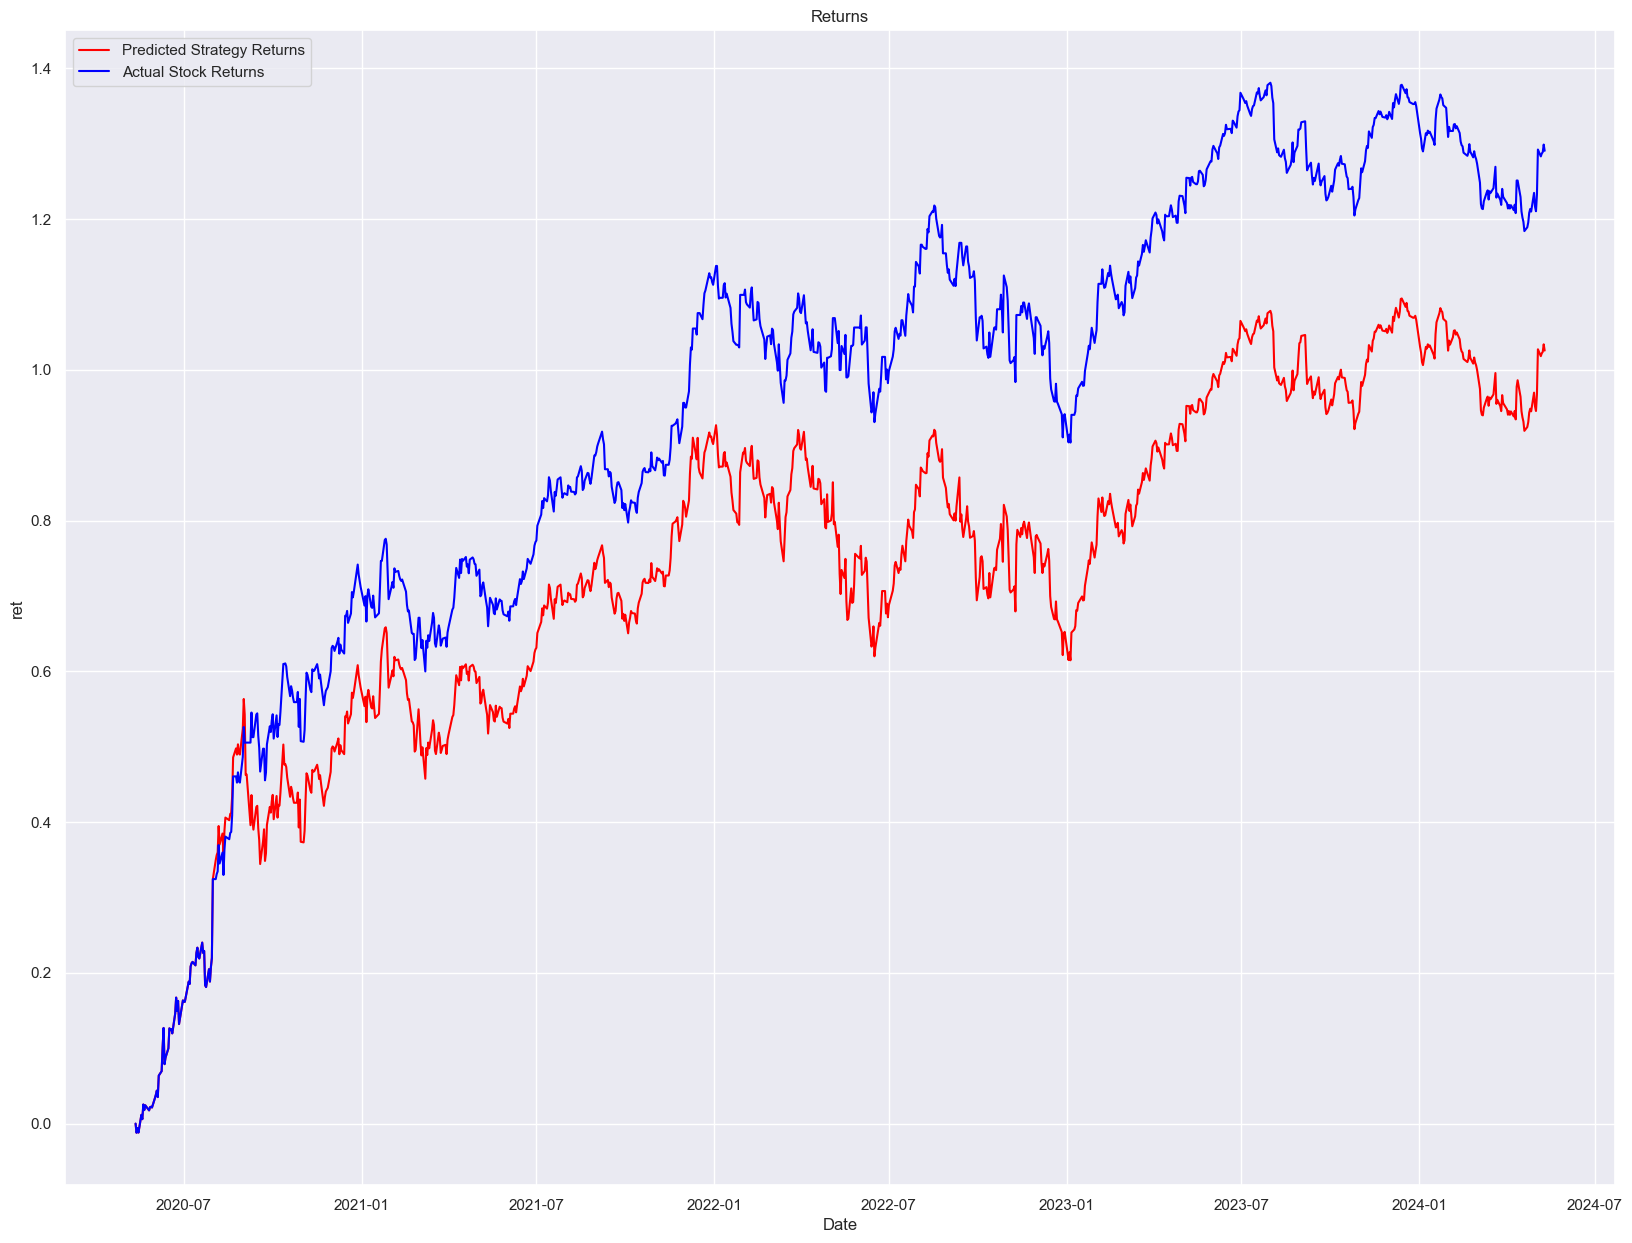

Train - Test Split :  80.0 - 19.999999999999996
The model's score for the Test Set came out to be :  0.38613861386138615
The model's score for the Validation Set came out to be :  0.5544554455445545


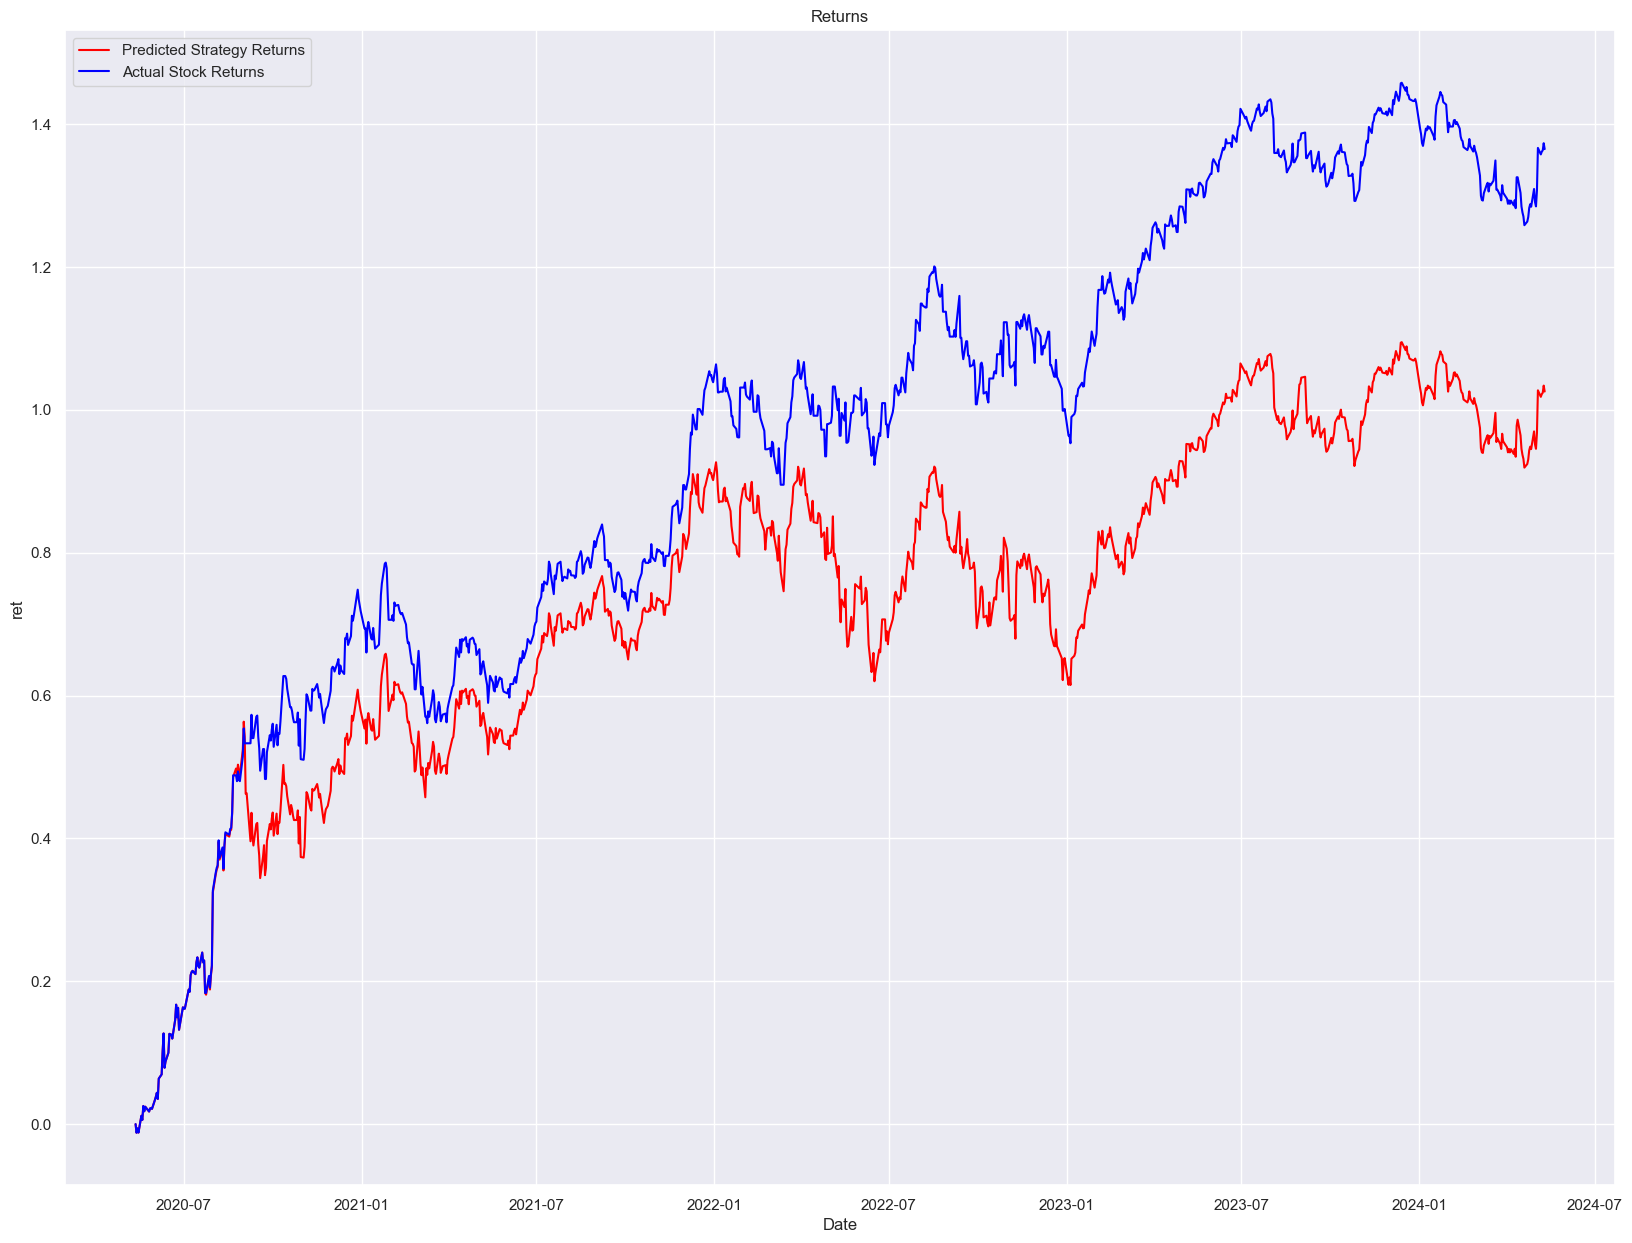

In [14]:
test_percentages = [0.2,0.4,0.6,0.8]

for p in test_percentages:
  print("Train - Test Split : ",(p)*100,"-",(1-p)*100)
  x_train,y_train,x_val,y_val,x_test,y_test = time_series_cross_validation(apple_stocks,buy_or_sell,p)
  SVC_Classifier(apple_stocks,x_train,y_train,x_val,y_val,x_test,y_test,temp)

